In [1]:
%matplotlib inline
import math
import numpy as num
import matplotlib.pyplot as plt

In [2]:
km = 1000.
hours = 3600.
days = hours * 24.

# ----------------- physical model parameter ----------------------------
chi0 = 10.        # susceptibility
depthS = -0.2     # Tiefe der Einflussfunktion 

# ----------------- parameter to modify starting state
Sshadow = 0.0    # initial stress shadow , usually set to zero

# ----------------- discretisation parameter -----------------------------
deltat = 0.2*hours  # sampleinterval in t in seconds
deltaS = 0.01       # sampling of Coulomb stress axis
sigma_max = 10.0

# ----------------- stress loading models -------------
# 1. step function overlaying steady stressing rate
n1 = 50          # fist phase must be larger at least 2
n2 = 51          # second phase at least n1+1, better n1+2 as central differences taken
sc0 = 0.0        # Coulomb stress values
sc1 = 0.5
sc2 = 1.0
sc3 = 2.0
# In dem Beispiel gibt es 150 Samples (30 /0.2 ). Tectonic rate wird aus ersten 50 sample berechnet, 
tectstressrate = (sc1-sc0)/(n1*deltat)

In [3]:
def gridrange(amin, amax, astep, rounding=math.ceil):
    amin = float(amin)
    amax = float(amax)
    astep = float(astep)
    na = int(rounding((amax-amin)/astep))
    amax = amin + (na-1) * astep
    a = num.linspace(amin, amax, na)
    return amin, amax, na, a

In [4]:
# ------------------ Coulomb stress axis , p und chi initialisieren  ----
smin, smax, nsigma, sigma = gridrange(-sigma_max, +sigma_max, deltaS)
chiz = num.zeros(nsigma)
pz  = num.zeros(nsigma)
print(-sigma_max, sigma_max, deltaS)
print(smin, smax, nsigma, sigma.shape)

-10.0 10.0 0.01
-10.0 9.990000000000002 2000 (2000,)


In [5]:
tmin, tmax, nt, t = gridrange(0*hours, 30*hours, deltat)
cf    = num.zeros(nt)
ratez  = num.zeros(nt)
chi1  = num.zeros(nt)
neqz  = num.zeros(nt-1)
print(0*hours, 30*hours, deltat)
print(tmin, tmax, nt, t.shape)

0.0 108000.0 720.0
0.0 107280.0 150 (150,)


0 to 50 sc0= 0.0 sc1= 0.5
50 to 51 sc1= 0.5 sc2= 1.0
51 to 150 sc2= 1.0 sc3= 2.0


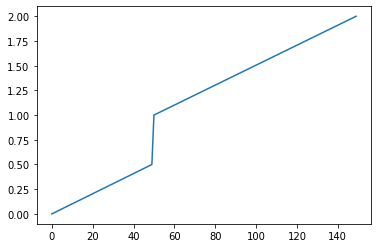

In [6]:
# print(cf)
print(0, "to", n1, "sc0=", sc0, "sc1=", sc1)
for i in range(0,n1):
    cf[i] = sc0 + i*(sc1-sc0)/float(n1-1)
# print(cf)
print(n1, "to", n2, "sc1=", sc1, "sc2=", sc2)
for i in range(n1,n2):
    cf[i] = cf[n1-1] + (i-n1+1)*(sc2-sc1)/float(n2-n1)
# print(cf)
print(n2, "to", nt, "sc2=", sc2, "sc3=", sc3)
for i in range(n2,nt):
    cf[i] = cf[n2-1] + (i-n2+1)*(sc3-sc2)/float(nt-n2)
# print(cf)

plt.plot(cf)

In [7]:
cf2 = num.hstack([
    num.linspace(sc0, sc1, num=n1),
    num.linspace(sc1, sc2, num=n2-n1+1)[1:],
    num.linspace(sc2, sc3, num=nt-n2+1)[1:],
])
assert num.allclose(cf, cf2)

In [8]:
pz = num.heaviside(sigma, 1)

[0. 0. 0. ... 1. 1. 1.]
[-10.    -9.99  -9.98 ...   9.97   9.98   9.99]


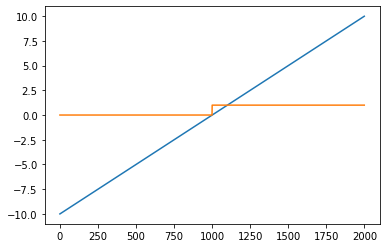

In [9]:
print(pz)
print(sigma)
plt.plot(sigma)
plt.plot(pz)

In [10]:
ndepth  = num.around(depthS/deltaS, 0).astype(int)
nzero = int(nsigma/2)
print(ndepth, nzero)

-20 1000


nzero= 1000  ndepth= -20


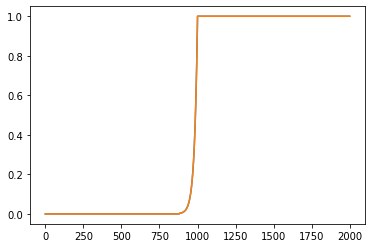

In [11]:
pz = num.heaviside(sigma, 1)
pz2 = pz.copy()
pz2[nzero+6*ndepth:nzero] = num.exp(-num.arange(6*ndepth, 0)/ndepth)

for k in range(0,-6*ndepth):
    pz[nzero+6*ndepth+k] = num.exp((-6*ndepth-k)/ndepth) # einfache e Abfall
    
plt.plot(pz)
plt.plot(pz2)
assert num.allclose(pz, pz2)
print('nzero=',nzero,' ndepth=',ndepth)

In [12]:
def shifted(x, nshift):
    # other option: use padding and cut
    x = num.roll(x, nshift)
    if (nshift > 0):
        x[0:nshift] = 1.0
    elif (nshift < 0):
        x[nshift:] = 0.0
    return x

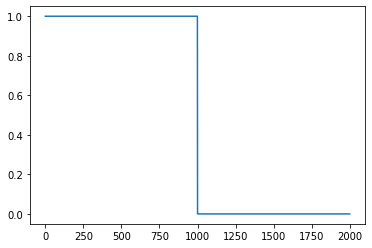

In [13]:
chiz = num.heaviside( -sigma , 0 )
chiz_before = chiz.copy()
plt.plot(chiz)
# print(sigma)
# print(pz)

# ...... initiale stress shadow falls noetig
nshift  = num.around(Sshadow/deltaS,0).astype(int)
chiz = shifted(chiz, nshift)

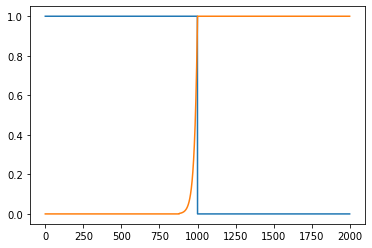

In [14]:
ratez[0] = 0.0
chiz = num.heaviside( -sigma , 0 )
resid = 0.
plt.plot(chiz)
plt.plot(pz) # this one is smooth and does not shift

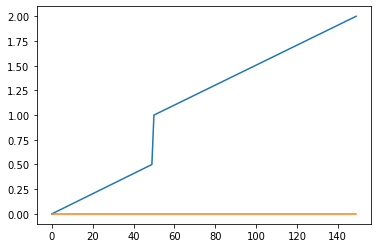

In [15]:
plt.plot(cf)
plt.plot(ratez)

10


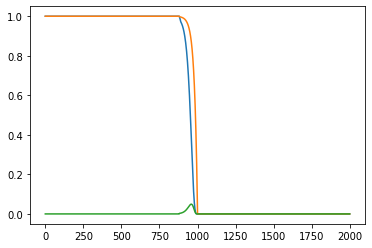

20


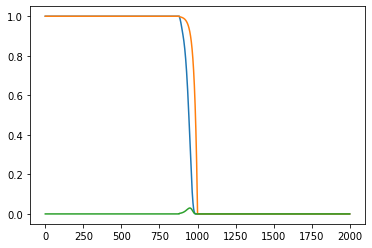

30


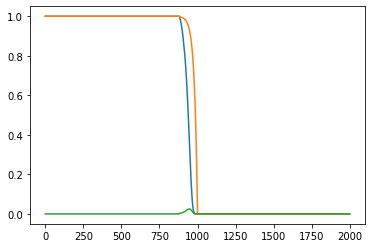

40


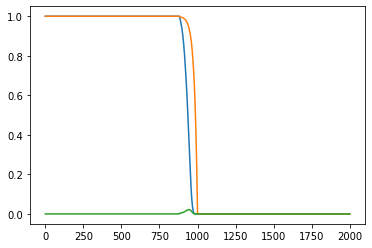

50


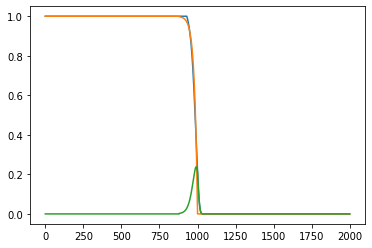

60


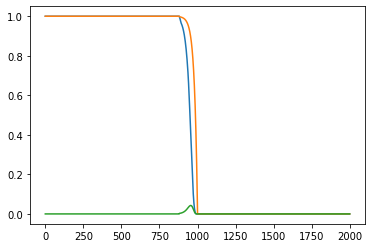

70


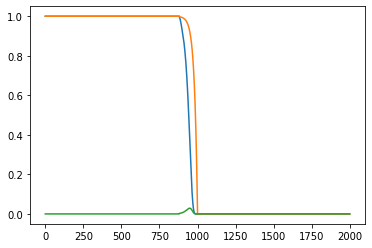

80


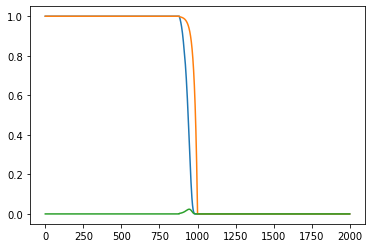

90


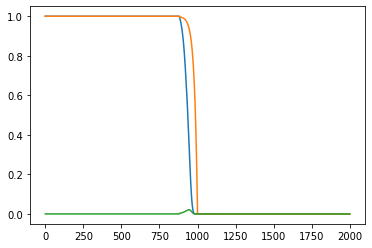

100


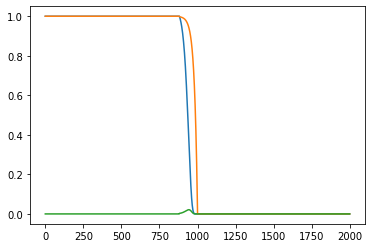

110


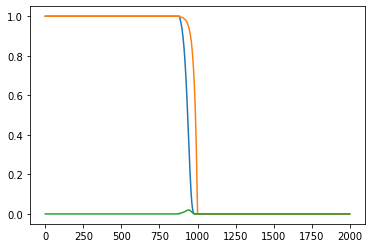

120


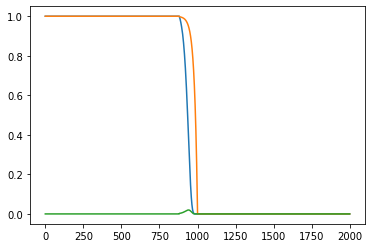

130


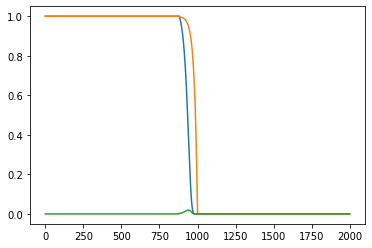

140


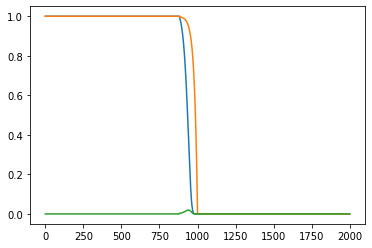

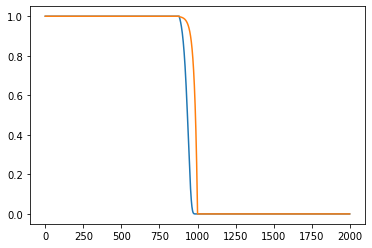

In [16]:
for i in range(1,nt)[:]:
    deltacf = cf[i]-(cf[i-1]-resid)
    nshift  = num.around(deltacf/deltaS,0).astype(int)
    resid = deltacf - nshift*deltaS
    # print("delta", deltacf, "shift", nshift, "resid", resid)
    chiz = shifted(chiz, nshift)
    if i % 10 == 0:
        print(i)
        plt.plot(chiz)
        # plt.plot(cf)
        plt.plot(1. - pz)
        plt.plot(chiz*pz)
        plt.show()
        plt.close()
    #chiz = num.roll(chiz,nshift)
    #if (nshift > 0):
    #    chiz[0:nshift] = 1.0
    #elif (nshift < 0):
    #    chiz[nshift:] = 0.0
    ratez[i] = num.trapz(chiz*pz)*deltaS
    # continue

    # ---- Anpassen von chi (memory effect)
    chiz = chiz*(1.-pz)

# plt.plot(chiz_before)
# plt.plot(chiz*pz)
plt.plot(chiz)
plt.plot(1.-pz)
# plt.plot(pz)
# ratez = ratez*chi0/deltat

In [21]:
c0 = 0.
neqz = num.zeros(nt-2)
neqz[0] = c0
for i in range(1,nt-2):
    neqz[i] = num.trapz(ratez[0:i+1])

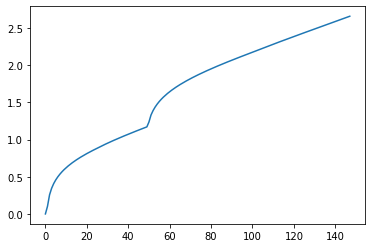

In [22]:
plt.plot(neqz)